In [29]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageDraw

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
CLASS_NAMES = {
    0: "Caries",
    1: "Crown",
    2: "Filling",
    3: "Implant",
    4: "Malaligned",
    5: "Mandibular Canal",
    6: "Missing teeth",
    7: "Periapical lesion",
    8: "Retained root",
    9: "Root Canal Treatment",
    10: "Root Piece",
    11: "impacted tooth",
    12: "maxillary sinus",
    13: "Bone Loss",
    14: "Fracture teeth",
    15: "Permanent Teeth",
    16: "Supra Eruption",
    17: "TAD",
    18: "abutment",
    19: "attrition",
    20: "bone defect",
    21: "gingival former",
    22: "metal band",
    23: "orthodontic brackets",
    24: "permanent retainer",
    25: "post - core",
    26: "plating",
    27: "wire",
    28: "Cyst",
    29: "Root resorption",
    30: "Primary teeth"
}

In [4]:
def load_yolo_segmentation_dataset(images_dir, labels_dir):
    dataset = []
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    for img_filename in image_files:
        img_path = os.path.join(images_dir, img_filename)
        label_filename = os.path.splitext(img_filename)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_filename)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Пропущено: не удалось загрузить {img_path}")
            continue
        h, w = img.shape[:2]

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = list(map(float, line.strip().split()))
                if len(parts) < 7:  # class_id + минимум 3 точки
                    continue

                class_id = int(parts[0])
                if class_id not in CLASS_NAMES:
                    print(f"Неизвестный class_id {class_id} в файле {label_filename}")
                    continue

                coords_norm = parts[1:]
                xs = [coords_norm[i] for i in range(0, len(coords_norm), 2)]
                ys = [coords_norm[i+1] for i in range(0, len(coords_norm), 2)]

                x_min = min(xs) * w
                y_min = min(ys) * h
                x_max = max(xs) * w
                y_max = max(ys) * h

                width = x_max - x_min
                height = y_max - y_min
                area = width * height

                annotations.append({
                    "class_id": class_id,
                    "class_name": CLASS_NAMES[class_id],
                    "bbox": [x_min, y_min, width, height],
                    "area": area,
                    "segmentation": coords_norm,
                    "image_width": w,
                    "image_height": h
                })

        dataset.append({
            "image_id": len(dataset),
            "file_name": img_filename,
            "width": w,
            "height": h,
            "annotations": annotations
        })

    print(f"Загружено изображений: {len(dataset)}")
    print(f"Всего объектов: {sum(len(img['annotations']) for img in dataset)}")
    return dataset

In [5]:
DATASET_ROOT = "/content/drive/MyDrive/TEETH_SEG"
TEST_IMAGES_DIR = os.path.join(DATASET_ROOT, "test", "images")
TEST_LABELS_DIR = os.path.join(DATASET_ROOT, "test", "labels")

dataset = load_yolo_segmentation_dataset(TEST_IMAGES_DIR, TEST_LABELS_DIR)

✅ Загружено изображений: 264
✅ Всего объектов: 3480


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_random_images_from_dataset(dataset, num_images=3):
    selected_indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

    fig, axes = plt.subplots(1, len(selected_indices), figsize=(6 * len(selected_indices), 6))
    if len(selected_indices) == 1:
        axes = [axes]

    np.random.seed(42)
    colors = [(int(r*255), int(g*255), int(b*255)) for r, g, b in np.random.rand(31, 3)]

    for i, idx in enumerate(selected_indices):
        img_info = dataset[idx]
        img_path = os.path.join(TEST_IMAGES_DIR, img_info["file_name"])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        w, h = img_info["width"], img_info["height"]

        for ann in img_info["annotations"]:
            class_id = ann["class_id"]
            color = colors[class_id]
            bbox = ann["bbox"]
            seg = ann["segmentation"]

            x_min, y_min, width, height = bbox
            x_max, y_max = x_min + width, y_min + height
            cv2.rectangle(img_rgb, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)

            mask_points = []
            for j in range(0, len(seg), 2):
                x = int(seg[j] * w)
                y = int(seg[j+1] * h)
                mask_points.append([x, y])
            mask_points = np.array(mask_points, dtype=np.int32)
            cv2.polylines(img_rgb, [mask_points], isClosed=True, color=color, thickness=1)

            class_name = ann["class_name"]
            cv2.putText(img_rgb, class_name, (int(x_min), int(y_min) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3)
            cv2.putText(img_rgb, class_name, (int(x_min), int(y_min) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

        axes[i].imshow(img_rgb)
        axes[i].set_title(f"{img_info['file_name']}\n{len(img_info['annotations'])} объектов")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

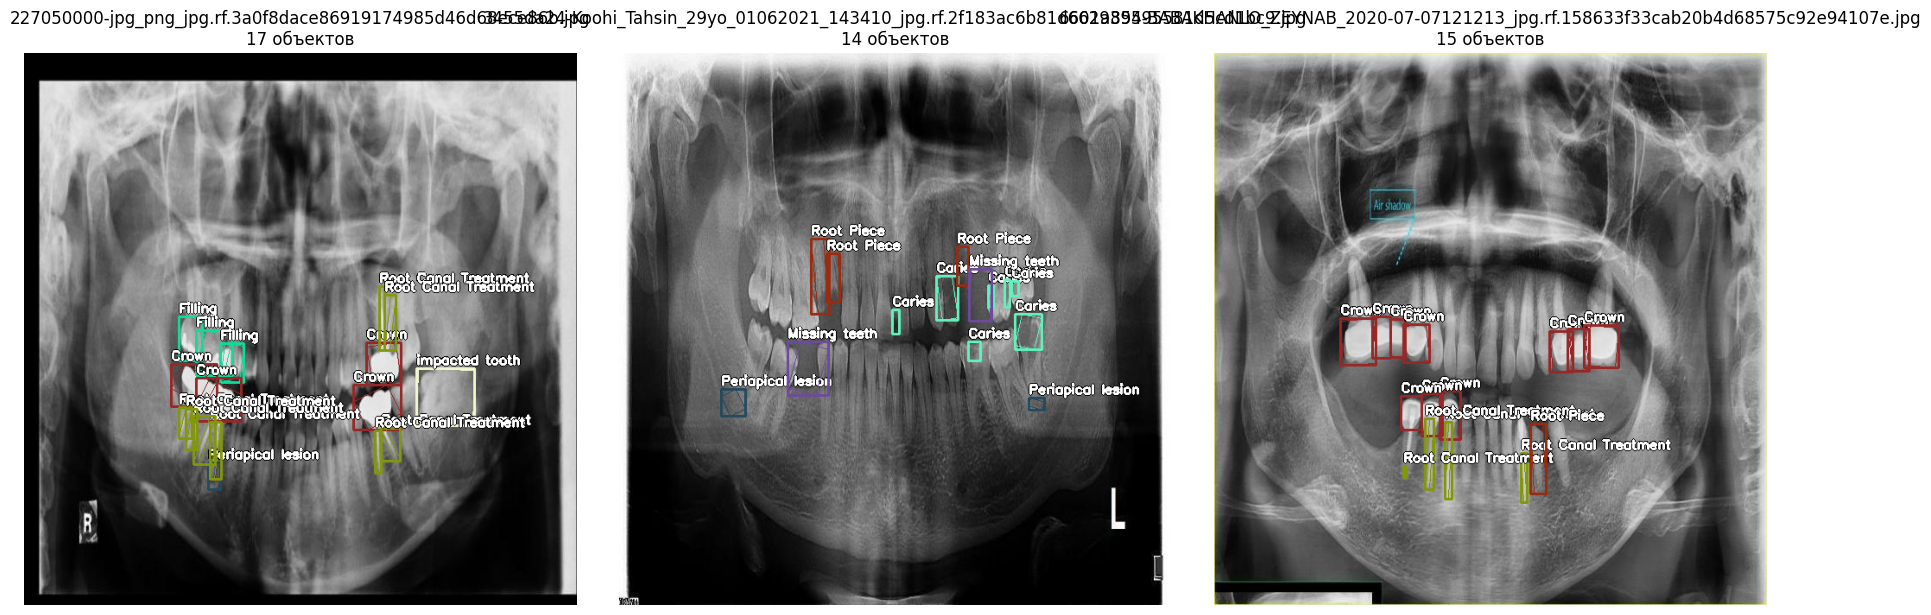

In [11]:
visualize_random_images_from_dataset(dataset, num_images=3)

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

object_sizes = []
class_counts = {}

for img_info in dataset:
    for ann in img_info["annotations"]:
        object_sizes.append(ann["area"])
        class_name = ann["class_name"]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

df_sizes = pd.DataFrame({'area': object_sizes})
df_classes = pd.DataFrame(list(class_counts.items()), columns=['class', 'count'])

In [13]:
df_classes

,class,count
0,Retained root,6
1,impacted tooth,397
2,Caries,603
3,Filling,1038
4,Crown,374
5,Root Canal Treatment,600
6,Missing teeth,139
7,Periapical lesion,150
8,Implant,36
9,Root Piece,133


In [14]:
df_sizes

,area
0,1710.518216
1,7173.613268
2,9298.140145
3,7773.040364
4,5369.564880
...,...
3475,361.830384
3476,853.771862
3477,1465.203450
3478,465.551723


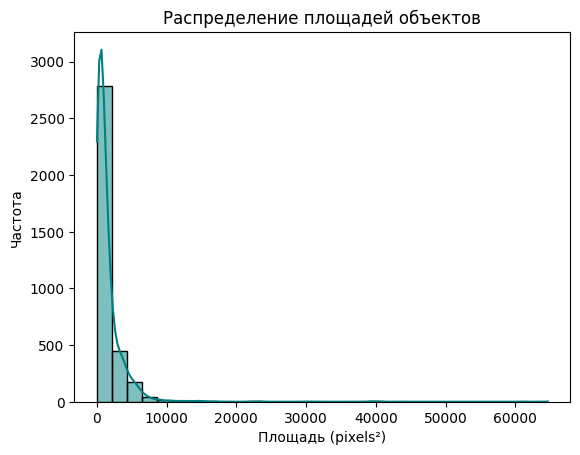

In [15]:
# Гистограмма площадей
sns.histplot(df_sizes['area'], bins=30, kde=True, color='teal')
plt.title('Распределение площадей объектов')
plt.xlabel('Площадь (pixels²)')
plt.ylabel('Частота')
plt.show()

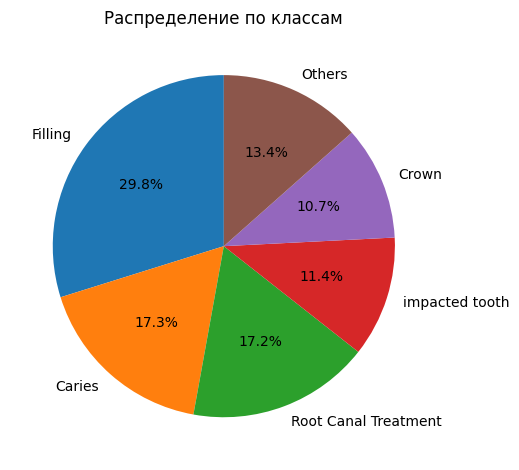

In [16]:
# Pie-chart
df_classes_sorted = df_classes.sort_values('count', ascending=False)
top_n = 5
if len(df_classes_sorted) > top_n:
    top_classes = df_classes_sorted.head(top_n)
    others_count = df_classes_sorted.iloc[top_n:]['count'].sum()
    top_classes = pd.concat([top_classes, pd.DataFrame([{'class': 'Others', 'count': others_count}])], ignore_index=True)
else:
    top_classes = df_classes_sorted

plt.pie(top_classes['count'], labels=top_classes['class'], autopct='%1.1f%%', startangle=90)
plt.title('Распределение по классам')

plt.tight_layout()
plt.show()

In [20]:
print("\nТоп-10 самых частых классов\n")
print(df_classes.sort_values('count', ascending=False).head(10).to_string(index=False))

print(f"\nВсего классов с аннотациями: {len(class_counts)} из 31")
print(f"Общее число объектов: {sum(class_counts.values())}")

# Дисбаланс
counts = list(class_counts.values())
imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')


if imbalance_ratio > 5:
    print("\nОбнаружен значительный дисбаланс классов.")
    rare_classes = [cls for cls, cnt in class_counts.items() if cnt <= 5]
    if rare_classes:
        print(f"\nРедкие классы (≤5 объектов): {', '.join(rare_classes)}")
else:
    print("Классы относительно сбалансированы.")


Топ-10 самых частых классов

               class  count
             Filling   1038
              Caries    603
Root Canal Treatment    600
      impacted tooth    397
               Crown    374
   Periapical lesion    150
       Missing teeth    139
          Root Piece    133
             Implant     36
       Retained root      6

Всего классов с аннотациями: 11 из 31
Общее число объектов: 3480

Обнаружен значительный дисбаланс классов.

Редкие классы (≤5 объектов): Mandibular Canal


In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_single_image_with_masks(image_path, class_names=None):

    if class_names is None:
        class_names = CLASS_NAMES  # используем глобальный словарь

    # Получаем путь к аннотации
    label_path = image_path.replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'

    # Загружаем изображение
    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Цвета для классов (до 31)
    np.random.seed(42)
    colors = [(int(r*255), int(g*255), int(b*255)) for r, g, b in np.random.rand(31, 3)]

    # Читаем аннотации
    if not os.path.exists(label_path):
        print(f"Файл аннотаций не найден: {label_path}")
    else:
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = list(map(float, line.strip().split()))
            if len(parts) < 7:  # class_id + минимум 3 точки
                continue

            class_id = int(parts[0])
            if class_id not in class_names:
                print(f"Неизвестный class_id {class_id} в файле {label_path}")
                continue

            coords_norm = parts[1:]

            # Денормализуем координаты маски
            mask_points = []
            for j in range(0, len(coords_norm), 2):
                x_norm = coords_norm[j]
                y_norm = coords_norm[j + 1]
                x = int(x_norm * w)
                y = int(y_norm * h)
                mask_points.append([x, y])
            mask_points = np.array(mask_points, dtype=np.int32)

            # Рисуем полигон маски
            color = colors[class_id]
            cv2.polylines(img_rgb, [mask_points], isClosed=True, color=color, thickness=2)

            # Вычисляем и рисуем bounding box
            x_min = mask_points[:, 0].min()
            y_min = mask_points[:, 1].min()
            x_max = mask_points[:, 0].max()
            y_max = mask_points[:, 1].max()
            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), color, 2)

            # Подпись класса
            class_name = class_names[class_id]
            cv2.putText(img_rgb, class_name, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)
            cv2.putText(img_rgb, class_name, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    # Отображаем
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(f"Аннотации для:\n{os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

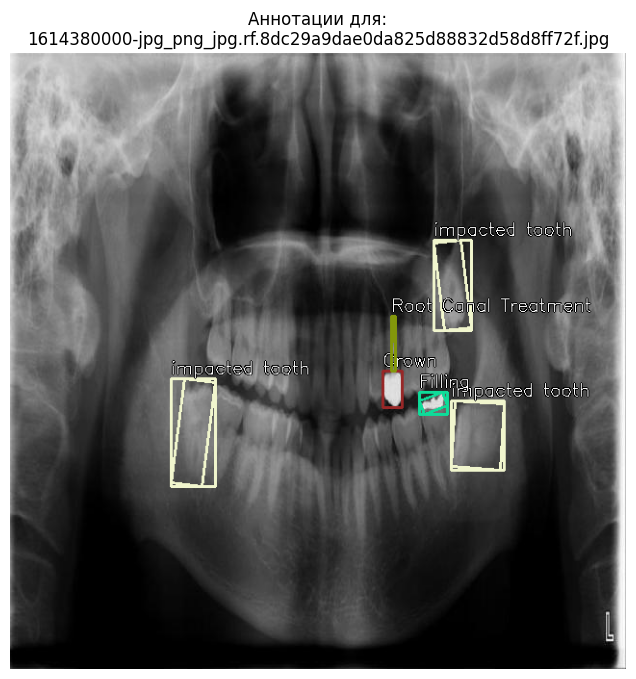

In [32]:
image_path = "/content/drive/MyDrive/TEETH_SEG/test/images/1614380000-jpg_png_jpg.rf.8dc29a9dae0da825d88832d58d8ff72f.jpg"

visualize_single_image_with_masks(image_path, class_names=CLASS_NAMES)